<a href="https://colab.research.google.com/github/egitimplus/ysa_uskudar/blob/main/YAPAY_S%C4%B0N%C4%B0R_A%C4%9ELARI_Ara_s%C4%B1nav_%C3%96devi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YAPAY SİNİR AĞLARI - ARA SINAV (ÖDEV)

Yunus Emre Çevik

Öğrenci No: 234329053

https://github.com/egitimplus/ysa_uskudar/blob/main/YAPAY_S%C4%B0N%C4%B0R_A%C4%9EI_Ara_s%C4%B1nav_%C3%96devi.ipynb

# 1. Gerekli Kütüphanelerin Yüklenmesi

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# SciPy
from scipy.stats import uniform, randint

# Torch
import torch
from torchvision import transforms
from torchvision.datasets import GTSRB

# Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin

# Tenserflow
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Layer, Dense, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

"""
0 = all messages are logged (default behavior)
1 = INFO messages are not printed
2 = INFO and WARNING messages are not printed
3 = INFO, WARNING, and ERROR messages are not printed
"""

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

warnings.filterwarnings('ignore')


# 2. Veri Seti Yükleme ve Ön İşleme

## a.	Veri Yükleme:


GTSRB veri seti pytorch kütüphanesinden indirildi ve kaydedildi. Her görüntünün boyutu 32x32 piksel olarak ayarlandı ve tensöre dönüştürüldü. Veri setinde 26640 tane gözlem olduğu tespit edildi.

In [ ]:
# Torch kütüphanesinden GTSRB yükleyelim
# German Traffic Sign Recognition Benchmark (GTSRB) Dataset.
# https://pytorch.org/vision/main/generated/torchvision.datasets.GTSRB.html


# GTSRB veri setini indir ve yükle
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor()
])

dataset = GTSRB(root='data/', download=True, transform=transform)


# Veri seti boyutunu kontrol edelim
len(dataset)

100%|██████████| 187M/187M [00:01<00:00, 110MB/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb


26640

Veri setinde yer alan etiket ve resimler ayrıştırıldı.

In [ ]:
# Verileri ve etiketleri ayır
images = []
labels = []

for img, label in dataset:
    images.append(img.numpy())  # Görselleri numpy dizisine dönüştür
    labels.append(label)

# Numpy dizisine dönüştür
images = np.array(images)
labels = np.array(labels)

len(labels), len(images)

(26640, 26640)

Etiketler içerisinde 0 ve 42 arasında değişen sayılar bulunmaktadır. Bunların karşılıkları aşağıda verilmiştir.



```
Label	Traffic Sign
0	Speed limit (20km/h)
1	Speed limit (30km/h)
2	Speed limit (50km/h)
3	Speed limit (60km/h)
4	Speed limit (70km/h)
5	Speed limit (80km/h)
6	End of speed limit (80km/h)
7	Speed limit (100km/h)
8	Speed limit (120km/h)
9	No passing
10	No passing for vehicles over 3.5 metric tons
11	Right-of-way at the next intersection
12	Priority road
13	Yield
14	Stop
15	No vehicles
16	Vehicles over 3.5 metric tons prohibited
17	No entry
18	General caution
19	Dangerous curve to the left
20	Dangerous curve to the right
21	Double curve
22	Bumpy road
23	Slippery road
24	Road narrows on the right
25	Road work
26	Traffic signals
27	Pedestrians
28	Children crossing
29	Bicycles crossing
30	Beware of ice/snow
31	Wild animals crossing
32	End of all speed and passing limits
33	Turn right ahead
34	Turn left ahead
35	Ahead only
36	Go straight or right
37	Go straight or left
38	Keep right
39	Keep left
40	Roundabout mandatory
41	End of no passing
42	End of no passing by vehicles over 3.5 metric tons
```






In [ ]:
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42])

In [ ]:
len(np.unique(labels))

43

## b.	Eksik Değerlerin İşlenmesi:

#### Etikette eksiklik var mı?

Etiketler içerisinde boş (eksik) değer bulunamamıştır

In [ ]:
# Etiketlerde eksik değerleri kontrol etme
missing_labels = np.isnan(labels).sum()  # y_train içinde NaN değerlerin sayısı
print(f"Eksik etiket sayısı: {missing_labels}")

Eksik etiket sayısı: 0


#### Resimlerde eksiklik var mı?

Resimler içerisinde boş (eksik) değer bulunamamıştır


In [ ]:

# Eksik değerleri kontrol etme fonksiyonu
def check_missing_values(images):
    """
    np.isnan(img).any(): Görselde (img) herhangi bir NaN (Not a Number) değeri olup olmadığını kontrol eder. Eğer varsa, True döner.
    np.isinf(img).any(): Görselde herhangi bir Inf (sonsuz) değeri olup olmadığını kontrol eder.
    np.isfinite(img).all(): Eğer görselin tüm değerleri geçerli ise True döner. Aksi takdirde, görselde geçersiz bir değer (NaN veya Inf) varsa False döner.
    """

    for idx, img in enumerate(images):
        if np.isnan(img).any():  # Görselde herhangi bir NaN değeri var mı?
            print(f"Görsel {idx + 1} içinde NaN değeri bulundu.")
        if np.isinf(img).any():  # Görselde herhangi bir Inf değeri var mı?
            print(f"Görsel {idx + 1} içinde Inf (sonsuz) değeri bulundu.")
        if not np.isfinite(img).all():  # Hem NaN hem de Inf varsa
            print(f"Görsel {idx + 1} geçersiz (NaN veya Inf içeriyor).")
    else:
        print('Kontrol Tamalandı.')

# Eksik değerleri kontrol eder varsa eksik resim ID yazdırır.
check_missing_values(images)

Kontrol Tamalandı.


## c.	Veri Setini Eğitim ve Test Olarak Ayırma:

Veriler sklearn.model_selection.train_test_split fonksiyonunu kullanılarak %80 eğitim, %20 test olarak ikiye ayırılmıştır. 21.312 veri eğitim veri setinde, 5.328 veri ise test veri setinde bulunmaktadır.


In [ ]:
# Veriyi %80 train, %20 test olarak ayır
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

print(f'Train set: {X_train.shape}, {y_train.shape}')
print(f'Test set: {X_test.shape}, {y_test.shape}')

Train set: (21312, 3, 32, 32), (21312,)
Test set: (5328, 3, 32, 32), (5328,)


MLPClassifier iki boyutlu bir girdi beklediğinden, görselleri (num_samples, num_features) şeklinde yeniden düzenleriz.

In [ ]:
num_samples, channels, height, width = X_train.shape

X_train_flat = X_train.reshape(num_samples, -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

X_train_flat

array([[0.74509805, 0.7490196 , 0.7607843 , ..., 0.5568628 , 0.6039216 ,
        0.59607846],
       [0.06666667, 0.0627451 , 0.05490196, ..., 0.05098039, 0.05490196,
        0.05490196],
       [0.12941177, 0.22352941, 0.2509804 , ..., 0.15686275, 0.16470589,
        0.14901961],
       ...,
       [0.12941177, 0.12941177, 0.12941177, ..., 0.10196079, 0.10196079,
        0.10980392],
       [0.47058824, 0.47058824, 0.4627451 , ..., 0.5647059 , 0.5686275 ,
        0.5647059 ],
       [0.08235294, 0.07843138, 0.07058824, ..., 0.07450981, 0.07450981,
        0.07843138]], dtype=float32)

## d.	Özellik Ölçekleme (Feature Scaling):

GTSRB veri setini indir ve yükleme adımında transform (toTensor) yaptığımız için veri setindeki piksel değerleri 0-255 aralığından 0-1 aralığına dönüştürülmüştür.Verimiz halihazırda normalize edilmiş olduğundan ek bir feature scaling yapmamıza gerek yoktur.

In [ ]:
X_train_flat[0]

array([0.74509805, 0.7490196 , 0.7607843 , ..., 0.5568628 , 0.6039216 ,
       0.59607846], dtype=float32)

# 3. Model Eğitimi ve Hiperparametre Denemeleri

## a.	MLP Modeli

### Base Model

Modelimizi oluşturalım. Modelimiz için hiperparametre ayarlaması yapmadığımızda otomatik olarak aşağıdaki parametreleri almaktadır.

hidden_layer_sizes=(100,),
activation='relu',
learning_rate_init=0.001

accuracy_score ile modelin test setindeki doğruluğunu ölçelim. RBF modelinden sonra farklı performans ölçümleri yapacağız.

scikit-learn cuda desteklemediği için cuda kullanılamamıştır.

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')

# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)


Model Eğitildi
Train seti doğruluğu: 0.9943693693693694
Test seti doğruluğu: 0.9641516516516516


Train veri setine bakıldığında %99'a yakın bir doğruluk vardır ve test seti tahminlerinin doğruluğu ile arada yaklaşık %3 lük bir fark var. Aşırı öğrenmede train veri setini iyi öğrenirken test setini o kadar iyi tahmin edemiz. Aradaki bu fark arttıkça aşırı öğrenme yapmış diyebiliriz. Ancak örneğimizde sınır kabul edilebilecek %3 seviyelerinde çıkmış. Tahmin ettiğiniz sınıf aralığının da çok fazla (43) olması aşırı öğrenme ihtimalini düşürmektedir.

### Activation Parametresi Denemeleri

Base modelde activation parametresi olarak "relu" kullanılmış olup, aşağıda "tanh","logistic","identity" parametreleri denenmiştir. Bu parametrede yapılan değişiklikler sonuçları çok fazla etkilmemektedir.

#### activation='tanh'

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(activation='tanh', random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')

# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9959647147147147
Test seti doğruluğu: 0.9690315315315315


#### activation='logistic'

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(activation='logistic', random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')

# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9997184684684685
Test seti doğruluğu: 0.9787912912912913


#### activation='identity'

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(activation='identity', random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')

# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9668262012012012
Test seti doğruluğu: 0.93506006006006


### Learning Rate Parametresi Denemeleri

Base modelde learning_rate parametresi olarak "0.001" kullanılmış olup, aşağıda "0.005","0.01","0.1" parametreleri denenmiş olup, bu parametredeki yükseliş model başarısını azaltmaktadır. Buradan anlaşıldığı üzere yüksek öğrenme oranları, eğitimde eksik öğrenmeye (underfit) yol açabilir, düşük öğrenme oranları ise aşırı öğrenmeye (overfit) yol açabilir.

#### learning_rate_init=0.005

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(learning_rate_init=0.005, random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')

# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.824558933933934
Test seti doğruluğu: 0.8012387387387387


#### learning_rate_init=0.01

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(learning_rate_init=0.01, random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')


# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.18679617117117117
Test seti doğruluğu: 0.18055555555555555


#### learning_rate_init=0.1

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(learning_rate_init=0.1, random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')


# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.05405405405405406
Test seti doğruluğu: 0.05405405405405406


### Hidden Layer Size Parametresi Denemeleri

Farklı katmanlarda 50 ve 100 nöron sayıları denenmiş olup, nöron ve katman sayısının doğrusal bir etkiye sahip olmadığı görülmektedir.

#### Single Hidden Layer

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(hidden_layer_sizes=(100,), random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')


# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9943693693693694
Test seti doğruluğu: 0.9641516516516516


In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(hidden_layer_sizes=(50,), random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')


# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9574887387387387
Test seti doğruluğu: 0.9206081081081081


#### Two Hidden Layer

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(hidden_layer_sizes=(100,100), random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')


# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9839996246246246
Test seti doğruluğu: 0.9590840840840841


In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(hidden_layer_sizes=(50,50), random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')


# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9855480480480481
Test seti doğruluğu: 0.9532657657657657


#### Three Hidden Layer

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')


# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9860172672672672
Test seti doğruluğu: 0.9555180180180181


In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(hidden_layer_sizes=(50,50,50), random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')


# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9886448948948949
Test seti doğruluğu: 0.9542042042042042


### Parametreleri beraber deneyelim

hidden_layer_sizes=(100,100,100), learning_rate_init=0.005, activation='relu', random_state=42

In [ ]:
# MLP modelini tanımlayın
mlp = MLPClassifier(hidden_layer_sizes=(100,100,100), learning_rate_init=0.005, activation='relu', random_state=42)

# Modeli eğitme
mlp.fit(X_train_flat, y_train)

print('Model Eğitildi')

# Modelin train verisi üzerindeki doğruluğunu değerlendirme
mlp_y_train_pred = mlp.predict(X_train_flat)
accuracy_train = accuracy_score(y_train, mlp_y_train_pred)
print("Train seti doğruluğu:", accuracy_train)

# Modelin test verisi üzerindeki doğruluğunu değerlendirme
mlp_y_test_pred = mlp.predict(X_test_flat)
accuracy_test = accuracy_score(y_test, mlp_y_test_pred)

print("Test seti doğruluğu:", accuracy_test)

Model Eğitildi
Train seti doğruluğu: 0.9853134384384384
Test seti doğruluğu: 0.9611486486486487


In [ ]:
mlp.n_iter_

57

Aşağıdaki parametreleri denediğimizde test doğruluğu %96 civarında çıkmıştır. Bu doğruluğa ise 54 iterasyon sonucunda ulaşılmıştır.

hidden_layer_sizes=(100,100,100),
learning_rate_init=0.005,
activation='relu'


## b.	RBF Modeli

sklearn kütüphanesinde doğrudan RBF modeli bulunmadığından, Keras kütüphanesi kullanılmıştır.

TensorFlow, GPU'yu otomatik olarak algılar. Kodda tf.test.is_gpu_available() fonksiyonu ile GPU kullanılabilirliğini kontrol ediyoruz.

In [ ]:
# TensorFlow GPU Kontrolü
if tf.test.is_gpu_available():
    print("CUDA is available. Using GPU:", tf.config.list_physical_devices('GPU'))
else:
    print("CUDA is not available. Using CPU.")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


CUDA is available. Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Base Model

RBFLayer: Özelleştirilmiş bir katman olarak tanımlandı ve Gaussian benzeri bir RBF işlevi kullanıyor.

Model, RBF katmanını, ardından bir Dense katmanı ve en sonunda bir softmax çıkış katmanını içeriyor.


In [ ]:
class RBFLayer(Layer):
    def __init__(self, units, gamma=None, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.gamma = gamma

    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                                       shape=(self.units, input_shape[-1]),
                                       initializer='uniform',
                                       trainable=True)
        if self.gamma is None:
            self.gamma = 1.0 / (2.0 * (tf.math.reduce_std(self.centers) ** 2))
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Boyutların genişletilmesi
        inputs_expanded = tf.expand_dims(inputs, axis=1)  # (?, 1, features)
        centers_expanded = tf.expand_dims(self.centers, axis=0)  # (1, units, features)

        # Fark hesaplama
        diff = inputs_expanded - centers_expanded  # (?, units, features)

        # L2 normu (karesel farklar toplamı)
        l2 = tf.reduce_sum(tf.square(diff), axis=-1)  # (?, units)

        # RBF aktivasyonu
        return tf.exp(-self.gamma * l2)


# RBF Modeli Tanımı
def create_rbf_model(input_shape, rbf_units, dense_units, output_units):
    inputs = Input(shape=input_shape)
    x = RBFLayer(rbf_units)(inputs)
    x = Dense(dense_units, activation='relu')(x)
    outputs = Dense(output_units, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Hiperparametreler:

rbf_units: RBF katmanındaki nöron sayısı.
    
dense_units: Dense katmanındaki nöron sayısı.

output_units: Sınıf sayısı

In [ ]:
# Modelin oluşturulması ve eğitilmesi
input_shape = X_train_flat.shape[1:]  # Giriş şekli
rbf_units = 100  # RBF katmanındaki nöron sayısı
dense_units = 64  # Dense katmandaki nöron sayısı
output_units = len(np.unique(y_train))  # Sınıf sayısı

input_shape


(3072,)

In [ ]:
rbf_model = create_rbf_model(input_shape, rbf_units, dense_units, output_units)

# Modeli eğitme
rbf_model.fit(X_train_flat, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.0554 - loss: 3.7175 - val_accuracy: 0.0542 - val_loss: 3.6160
Epoch 2/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0563 - loss: 3.5964 - val_accuracy: 0.0544 - val_loss: 3.5498
Epoch 3/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0588 - loss: 3.5410 - val_accuracy: 0.0544 - val_loss: 3.5207
Epoch 4/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0561 - loss: 3.5174 - val_accuracy: 0.0544 - val_loss: 3.5084
Epoch 5/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0570 - loss: 3.5066 - val_accuracy: 0.0544 - val_loss: 3.5029
Epoch 6/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0551 - loss: 3.4960 - val_accuracy: 0.0544 - val_loss: 3.5005
Epoch 7/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0597 - loss: 3.5038 - val_accuracy: 0.0544 - val_loss: 3.4993
Epoch 8/10
533/533 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0590 - loss: 3.4978 - val_accuracy: 

In [ ]:
# RBF Model Test Sonuçları
y_pred_rbf = np.argmax(rbf_model.predict(X_test_flat), axis=1)

# Performans Metikleri
rbf_accuracy = accuracy_score(y_test, y_pred_rbf)
print("\nRBF Model Test Doğruluğu:", rbf_accuracy)

167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step

RBF Model Test Doğruluğu: 0.05630630630630631


Test seti doğruluğuna (%6) baktığımızda çok düşük çıkmıştır. Hem train hem de test verilerinde düşük performans olması eksik öğrenme olduğunu göstermektedir. Hiperparametre ayarları ve özellikle resimlerinin manipule edilerek (renk, boyut vb) yeniden denemeler yapılması başarının artırılmasında etkili olabilir.

# 4. Performans Ölçümleri

## a.	Confusion Matrix

### MLP Modeli Karışıklık Matrisi

Confusion Matrix bakıldığında doğruluğun yüksek olduğu görülmektedir.

Özellikle birbirine benzeyen ilk 5 levha için diğerlerine göre daha fazla yanlış tahminlerde bulunmuştur.



```
Tahmin 1 Gerçek 2 | 8 adet
Tahmin 2 Gerçek 1 | 7 adet
Tahmin 4 Gerçek 2 | 14 adet
Tahmin 5 Gerçek 3 | 14 adet
Tahmin 2 Gerçek 5 | 5 adet
Tahmin 3 Gerçek 5 | 4 adet

0	Speed limit (20km/h)
1	Speed limit (30km/h)
2	Speed limit (50km/h)
3	Speed limit (60km/h)
4	Speed limit (70km/h)
5	Speed limit (80km/h)
```


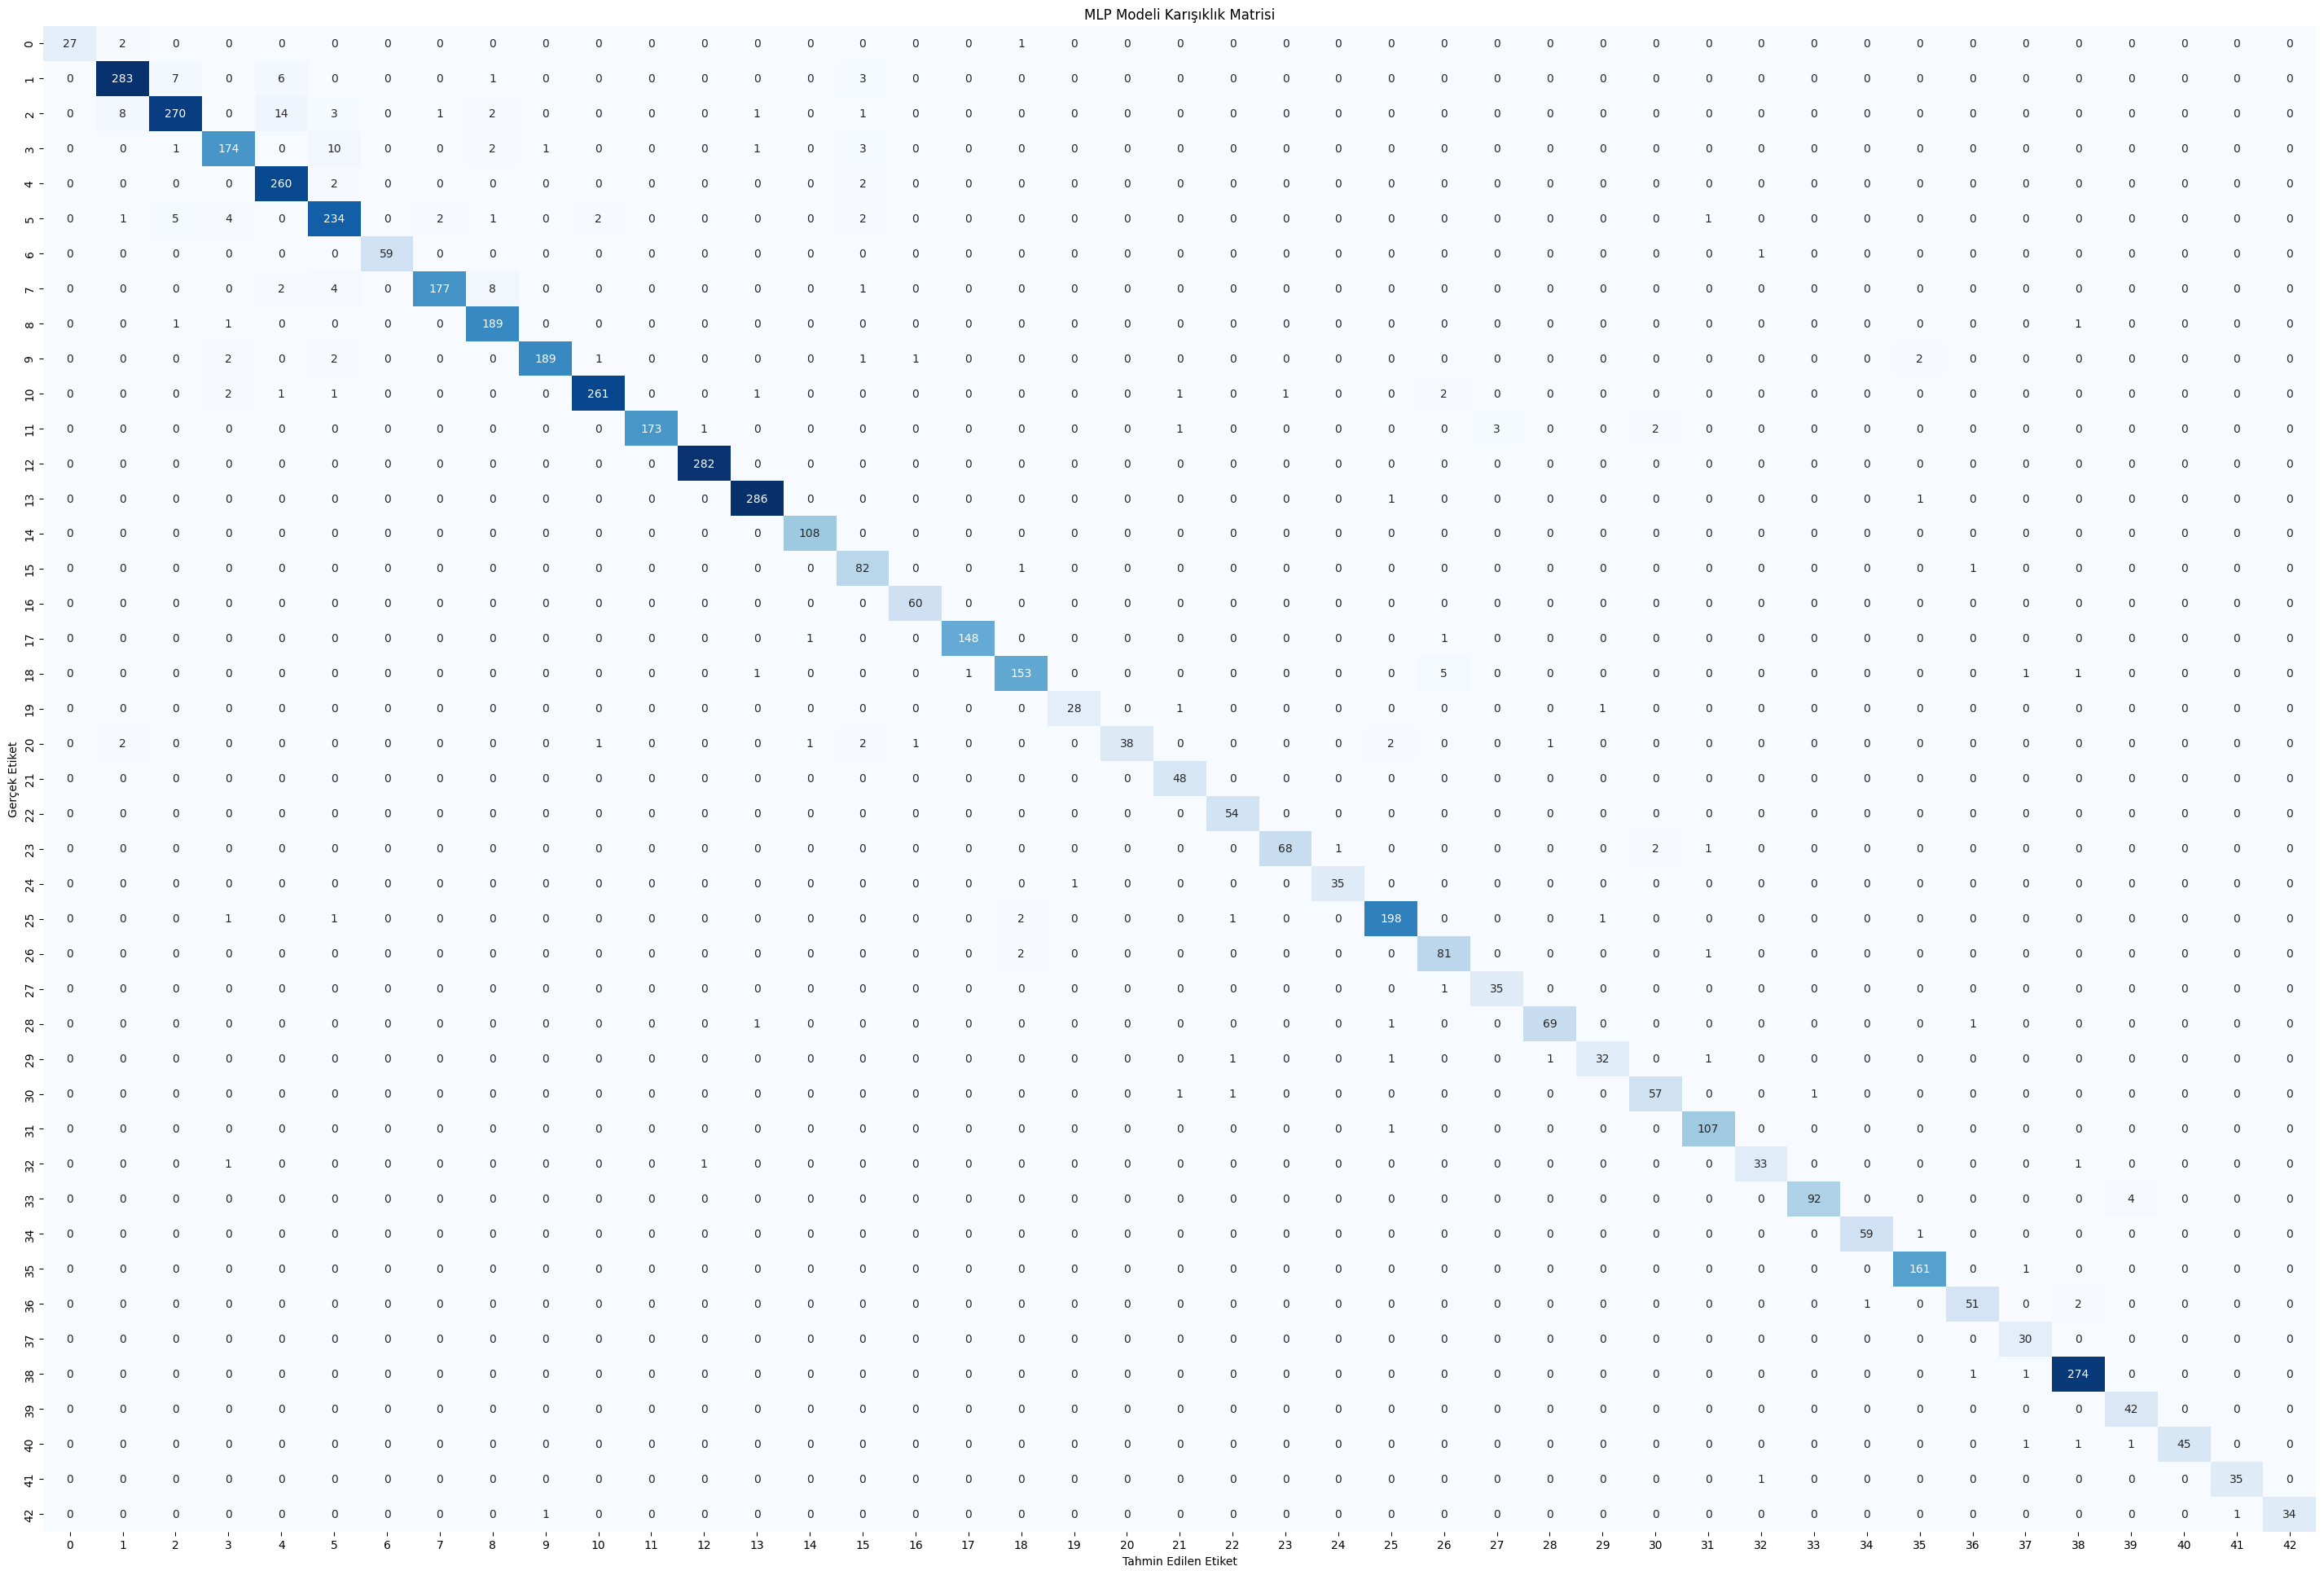

In [ ]:
cm_mlp = confusion_matrix(y_test, mlp_y_test_pred)

plt.figure(figsize = (36,24))
sns.heatmap(cm_mlp, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("MLP Modeli Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.show()

### RBF Modeli Karışıklık Matrisi

RBF Modeli neredeyse tüm tahminleri "2" (Speed limit (50km/h)
 ) dir. Bu da modelin az öğrendiğini desteklemektedir. İlerleyen aşamalarda hiperparametre optimizasyonu ile daha iyi sonuçlar almak için çalışmalar yapacağız.

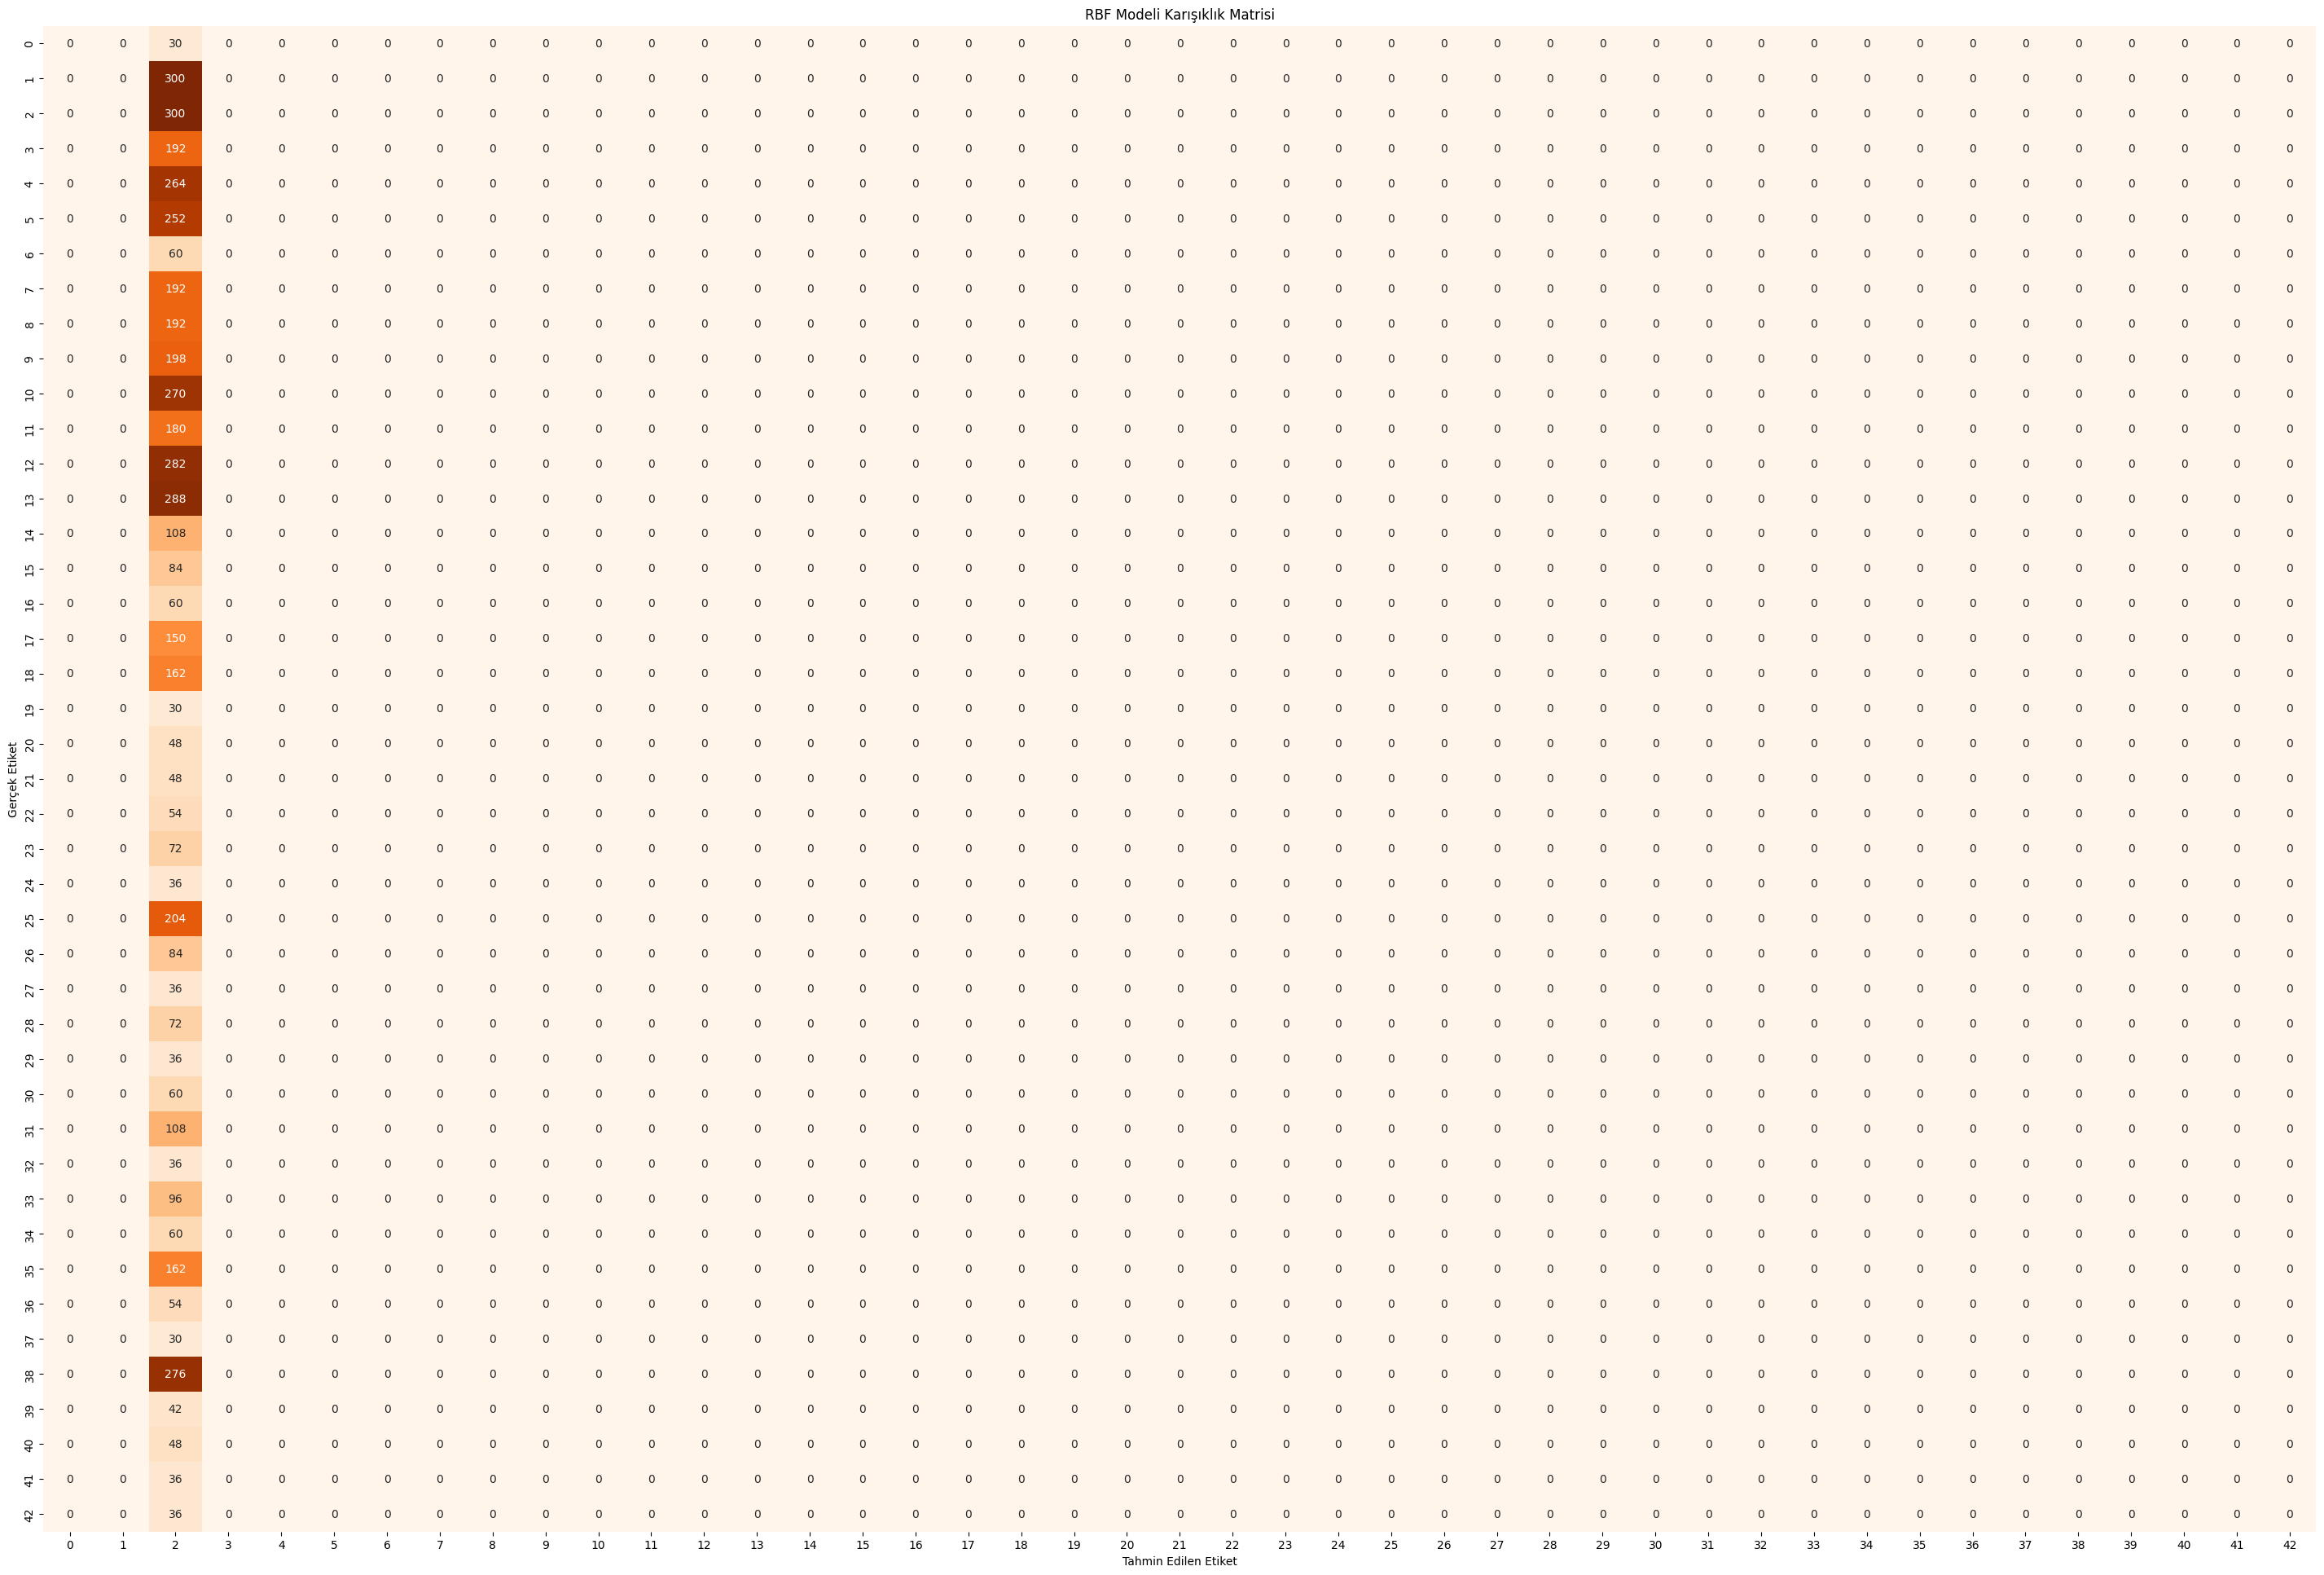

In [ ]:
cm_rbf = confusion_matrix(y_test, y_pred_rbf)
plt.figure(figsize = (36,24))
sns.heatmap(cm_rbf, annot=True, fmt="d", cmap="Oranges", cbar=False)
plt.title("RBF Modeli Karışıklık Matrisi")
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.show()


## b.	Performans Metrikleri:

### MLP Modeli Sınıflandırma Raporu

Sınıf bazında "precission", "recall" ve "f1-score" aşağıda verilmiştir. Modelin doğruluğu %96 hesaplanmış olup, diğer metrikler aşağıdaki tabloda verilmiştir.

In [ ]:
# MLP Modeli Değerlendirme
print(classification_report(y_test, mlp_y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.96      0.94      0.95       300
           2       0.95      0.90      0.92       300
           3       0.94      0.91      0.92       192
           4       0.92      0.98      0.95       264
           5       0.91      0.93      0.92       252
           6       1.00      0.98      0.99        60
           7       0.98      0.92      0.95       192
           8       0.93      0.98      0.96       192
           9       0.99      0.95      0.97       198
          10       0.98      0.97      0.98       270
          11       1.00      0.96      0.98       180
          12       0.99      1.00      1.00       282
          13       0.98      0.99      0.99       288
          14       0.98      1.00      0.99       108
          15       0.85      0.98      0.91        84
          16       0.97      1.00      0.98        60
          17       0.99    

### RBF Modeli Sınıflandırma Raporu

Sınıf bazında "precission", "recall" ve "f1-score" aşağıda verilmiştir. Modelin doğruluğu "%6" hesaplanmış olup, 2. sınıf hariç tüm metrikler sıfır olarak hesaplanmıştır.

In [ ]:
# RBF Modeli Değerlendirme
print(classification_report(y_test, y_pred_rbf))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00       300
           2       0.06      1.00      0.11       300
           3       0.00      0.00      0.00       192
           4       0.00      0.00      0.00       264
           5       0.00      0.00      0.00       252
           6       0.00      0.00      0.00        60
           7       0.00      0.00      0.00       192
           8       0.00      0.00      0.00       192
           9       0.00      0.00      0.00       198
          10       0.00      0.00      0.00       270
          11       0.00      0.00      0.00       180
          12       0.00      0.00      0.00       282
          13       0.00      0.00      0.00       288
          14       0.00      0.00      0.00       108
          15       0.00      0.00      0.00        84
          16       0.00      0.00      0.00        60
          17       0.00    

# 5. Hiperparametre Denemeleri ve Sonuçları Karşılaştırma

## a.	Hiperparametre Denemeleri

### MLP

Eğer kapsamlı bir arama yapmak ve parametrelerin küçük bir aralıkta hassas bir şekilde optimize edilmesi gerekiyorsa, GridSearchCV tercih edilebilir.
Eğer zaman ve kaynak kısıtlamalarınız varsa veya geniş bir parametre alanında daha hızlı bir şekilde iyi sonuçlar arıyorsanız, RandomizedSearchCV daha iyi bir seçim olabilir.

Daha hızlı sonuca ulaşabilmek için RandomizedSearchCV tercih ettim.

In [ ]:
# uniform(0.0001, 0.01) -> [0.0001, 0.01] aralığında rastgele değerler üretir.

# Hiperparametre aralıkları
param_dist = {
    'hidden_layer_sizes': [(64,), (128,), (64, 64), (128, 64), (128, 128), (128, 128, 128)],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': uniform(0.0001, 0.01),  # L2 düzenlileştirme
    'learning_rate_init': uniform(0.001, 0.01),
    'max_iter': [500, 1000]
}

# Model ve RandomizedSearchCV
mlp = MLPClassifier(random_state=42)
search_mlp = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=param_dist,
    n_iter=20,
    scoring='accuracy',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

search_mlp.fit(X_train_flat, y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=MLPClassifier(random_state=42), n_iter=20,
                   n_jobs=-1,
                   param_distributions={'activation': ['tanh', 'relu'],
                                        'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x78870c50f550>,
                                        'hidden_layer_sizes': [(64,), (128,),
                                                               (64, 64),
                                                               (128, 64),
                                                               (128, 128),
                                                               (128, 128, 128)],
                                        'learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7887dca04b50>,
                                        'max_iter': [500, 1000],
                                        'solver': ['adam', 'sgd']},
                   random_state=42, scoring='accuracy', verbose=2)

Yapılan hiperparametre optimizasyonu sonucunda MLP Modeli test doğruluğu %97.8 çıkmıştır

En iyi parametreler:

```
'activation': 'tanh',
'alpha': 0.008699404067363204,
'hidden_layer_sizes': (128, 128),
'learning_rate_init': 0.00550499251969543,
'max_iter': 1000,
'solver': 'sgd'
```


In [ ]:
# En iyi parametreler ve test sonucu

print("En iyi parametreler:", search_mlp.best_params_)

mlp_best_model = search_mlp.best_estimator_

y_pred_mlp = mlp_best_model.predict(X_test_flat)
mlp_accuracy = accuracy_score(y_test, y_pred_mlp)
print("MLP Model Test Doğruluğu:", mlp_accuracy)

En iyi parametreler: {'activation': 'tanh', 'alpha': 0.008699404067363204, 'hidden_layer_sizes': (128, 128), 'learning_rate_init': 0.00550499251969543, 'max_iter': 1000, 'solver': 'sgd'}
MLP Model Test Doğruluğu: 0.9780405405405406


#### MLP Classification Report

In [ ]:
print("MLP Classification Report:")
print(classification_report(y_test, y_pred_mlp))

MLP Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.96      0.97      0.97       300
           2       0.97      0.97      0.97       300
           3       0.95      0.96      0.96       192
           4       1.00      0.97      0.98       264
           5       0.94      0.96      0.95       252
           6       1.00      1.00      1.00        60
           7       0.98      0.99      0.99       192
           8       0.96      0.98      0.97       192
           9       0.99      0.99      0.99       198
          10       1.00      0.98      0.99       270
          11       0.99      0.98      0.99       180
          12       0.99      1.00      0.99       282
          13       0.98      0.98      0.98       288
          14       1.00      1.00      1.00       108
          15       0.94      0.95      0.95        84
          16       1.00      1.00      1.00        60


### RBF

In [ ]:
# RBF aktivasyon fonksiyonu
def rbf_activation(x, gamma=1.0):
    return K.exp(-gamma * K.square(x))

# RBF sınıfı
class RBFClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, hidden_neurons=100, learning_rate=0.001, gamma=1.0, epochs=20, batch_size=32):
        self.hidden_neurons = hidden_neurons
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        # Modeli oluştur
        self.model = Sequential()
        self.model.add(Dense(self.hidden_neurons, input_dim=X.shape[1], activation=lambda x: rbf_activation(x, self.gamma)))
        self.model.add(Dense(len(np.unique(y)), activation='softmax'))
        optimizer = Adam(learning_rate=self.learning_rate)
        self.model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Modeli eğit
        self.model.fit(X, y, batch_size=self.batch_size, epochs=self.epochs, verbose=0)
        return self

    def predict(self, X):
        return np.argmax(self.model.predict(X), axis=1)

# Hiperparametre aralıkları
param_dist = {
    'hidden_neurons': [50, 100, 150, 200],  # Gizli katmandaki nöron sayısı
    'learning_rate': [0.0001, 0.001, 0.01],  # Öğrenme oranı
    'gamma': [0.5, 1.0, 2.0],  # RBF gama parametresi
    'epochs': [10, 20, 30],  # Epoch sayısı
    'batch_size': [16, 32, 64]  # Mini-batch boyutu
}

# RandomizedSearchCV ile optimizasyon
rbf_clf = RBFClassifier()  # RBFClassifier örneği oluşturuluyor
random_search = RandomizedSearchCV(
    estimator=rbf_clf,
    param_distributions=param_dist,
    n_iter=20,  # Hiperparametre kombinasyonlarından test edilecek sayı
    scoring='accuracy',
    cv=3,  # 3 katlı çapraz doğrulama
    verbose=2,
    random_state=42,
    n_jobs=-1  # Paralel çalışma
)

# Modeli eğit
random_search.fit(X_train_flat, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomizedSearchCV(cv=3, estimator=RBFClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'batch_size': [16, 32, 64],
                                        'epochs': [10, 20, 30],
                                        'gamma': [0.5, 1.0, 2.0],
                                        'hidden_neurons': [50, 100, 150, 200],
                                        'learning_rate': [0.0001, 0.001, 0.01]},
                   random_state=42, scoring='accuracy', verbose=2)

Yapılan hiperparametre optimizasyonu sonucunda RBF Modeli test doğruluğu %69.2 çıkmıştır

En iyi parametreler:

```
'learning_rate': 0.0001,
'hidden_neurons': 50,
'gamma': 2.0,
'epochs': 10,
'batch_size': 32
```


In [ ]:
# Sonuçları değerlendirin
print("En iyi parametreler:", random_search.best_params_)
y_pred = random_search.best_estimator_.predict(X_test_flat)

rbf_accuracy = accuracy_score(y_test, y_pred)

print("Test doğruluğu:", accuracy_score(y_test, y_pred))

En iyi parametreler: {'learning_rate': 0.0001, 'hidden_neurons': 50, 'gamma': 2.0, 'epochs': 10, 'batch_size': 32}
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test doğruluğu: 0.6929429429429429


#### RBF Classification Report

In [ ]:
print("RBF Classification Report:")
print(classification_report(y_test, y_pred))

RBF Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.76      0.85      0.80       300
           2       0.59      0.83      0.69       300
           3       0.60      0.49      0.54       192
           4       0.77      0.67      0.72       264
           5       0.40      0.58      0.47       252
           6       0.69      0.18      0.29        60
           7       0.68      0.52      0.59       192
           8       0.42      0.54      0.47       192
           9       0.84      0.87      0.86       198
          10       0.70      0.98      0.81       270
          11       0.48      0.96      0.64       180
          12       0.79      0.99      0.88       282
          13       0.97      0.95      0.96       288
          14       0.99      0.96      0.98       108
          15       1.00      0.17      0.29        84
          16       1.00      0.52      0.68        60


# Sonuçları Karşılaştırma ve Yorumlama

In [ ]:
# Performans Sonuçları Tablosu
performance_results = pd.DataFrame({
    'Model': ['MLP', 'RBF'],
    'Accuracy': [mlp_accuracy, rbf_accuracy],
    'Best Params': [search_mlp.best_params_, random_search.best_params_]
})

print("\nPerformans Sonuçları:")
performance_results




Performans Sonuçları:


,Model,Accuracy,Best Params
0,MLP,0.978041,"{'activation': 'tanh', 'alpha': 0.008699404067..."
1,RBF,0.692943,"{'learning_rate': 0.0001, 'hidden_neurons': 50..."


MLP Modeli RBF modeline kıyasla daha başarılı sonuçlar üretmiş ve test veri setinin tahminlenmesinde %97.8 başarı göstermiştir. MLP ile en iyi sonuç bu veriseti için activation parametresi 'tanh' ve alpha değeri '0.00869' seçildiğinde alınmıştır. Diğer hiperparametreler için seçim yapılmamış default seçenekler kullanılmıştır.

